# Predicting User Adoption

<p>The objective of the following analysis is to identify the factors that help predict future user adoption. An 'adopted user' is defined as a user who has logged into the product on three separate days in at least one seven day period.</p>

In [1]:
# print all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# import modules
import pandas as pd
import numpy as np

In [3]:
# read files
with open('../data/takehome_users.csv', 'r', encoding='mac_roman', newline='') as f:
    users = pd.read_csv(f, encoding="utf-8", infer_datetime_format = True,parse_dates=['creation_time', 'last_session_creation_time'])

with open('../data/takehome_user_engagement.csv') as e:#, 'r', encoding='mac_roman', newline='') as e:
    engagement = pd.read_csv(e, parse_dates=['time_stamp'])


In [4]:
# confirm that the data was loaded
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1358849660,0,0,193,5240.0


In [5]:
# confirm data was loaded
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
# change unix time to pandas readable time using seconds as unit
users['last_session_creation_time']= pd.to_datetime(users['last_session_creation_time'], unit = 's')

#users['creation_time'] = pd.to_datetime(users['creation_time'])

In [7]:
engagement['time_stamp']= pd.to_datetime(engagement['time_stamp'], errors='coerce')

In [8]:
#users.head()
#engagement.head()

In [9]:
#df = pd.merge(users, engagement, left_on='object_id', right_on='user_id')
#df = df.set_index('time_stamp').sort_index()

In [10]:
# set time_stamp as index to resample the data every . 7 days
engagement = engagement.set_index('time_stamp').sort_index()

engagement = engagement.groupby('user_id')['visited'].rolling('7D').count()

engagement = engagement.reset_index().sort_index()
engagement.head()

,user_id,time_stamp,visited
0,1,2014-04-22 03:53:30,1.0
1,2,2013-11-15 03:45:04,1.0
2,2,2013-11-29 03:45:04,1.0
3,2,2013-12-09 03:45:04,1.0
4,2,2013-12-25 03:45:04,1.0


In [11]:
len(engagement.loc[engagement.visited>3])

132768

In [12]:
# find adopted users
adopted_users = engagement.loc[engagement.visited>=3]

In [13]:
adopted_users.head(2)

,user_id,time_stamp,visited
9,2,2014-02-09 03:45:04,3.0
10,2,2014-02-13 03:45:04,3.0


In [14]:
# create the target variable 
target = set(adopted_users['user_id'])

## Feature engineering

In [15]:
# combine two data sources
df = pd.merge(engagement, users, right_on = 'object_id', left_on='user_id')
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207917 entries, 0 to 207916
Data columns (total 13 columns):
user_id                       207917 non-null int64
time_stamp                    207917 non-null datetime64[ns]
visited                       207917 non-null float64
object_id                     207917 non-null int64
creation_time                 207917 non-null datetime64[ns]
name                          207917 non-null object
email                         207917 non-null object
creation_source               207917 non-null object
last_session_creation_time    207917 non-null datetime64[ns]
opted_in_to_mailing_list      207917 non-null int64
enabled_for_marketing_drip    207917 non-null int64
org_id                        207917 non-null int64
invited_by_user_id            116887 non-null float64
dtypes: datetime64[ns](3), float64(2), int64(5), object(3)
memory usage: 22.2+ MB


,user_id,time_stamp,visited,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,1.0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,1.0,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0


In [16]:
# split the moth and weekday of the day accounts were created
df['month'] = (df['creation_time'].dt.month).astype('category')
df['weekday'] = (df['creation_time'].dt.weekday).astype('category')

In [17]:
# create feature for the domain, duration and target variable
df['duration'] = (df['last_session_creation_time'] - df['creation_time']).dt.days
df['domain'] = df['email'].str.split('@').str[1]
df['target'] = [1 if x in target else 0 for x in df['user_id']]

In [18]:
# change strings into categorical features.
df['opted_in_to_mailing_list'] = df['opted_in_to_mailing_list'].astype('category')
df['enabled_for_marketing_drip'] = df['enabled_for_marketing_drip'].astype('category')
df['creation_source'] = df['creation_source'].astype('category')
df['domain'] = df['domain'].astype('category')

In [19]:
# remove second userid variable
del df['object_id']

In [20]:
df.head(2)

,user_id,time_stamp,visited,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,month,weekday,duration,domain,target
0,1,2014-04-22 03:53:30,1.0,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,4,1,0,yahoo.com,0
1,2,2013-11-15 03:45:04,1.0,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,11,4,136,gustr.com,1


In [21]:
# use only the unique user ids for the model
df = df.drop_duplicates('user_id')

In [22]:
# percentage of adopted users
(np.sum(df.target)/len(df)) * 100

18.157089425365523

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# 'double resolution plot output for Retina screens'
%config InlineBackend.figure_format = 'retina'

,weekday,0
0,0,1258
1,1,1232
2,2,1254
3,3,1316
4,4,1326
5,5,1215
6,6,1222


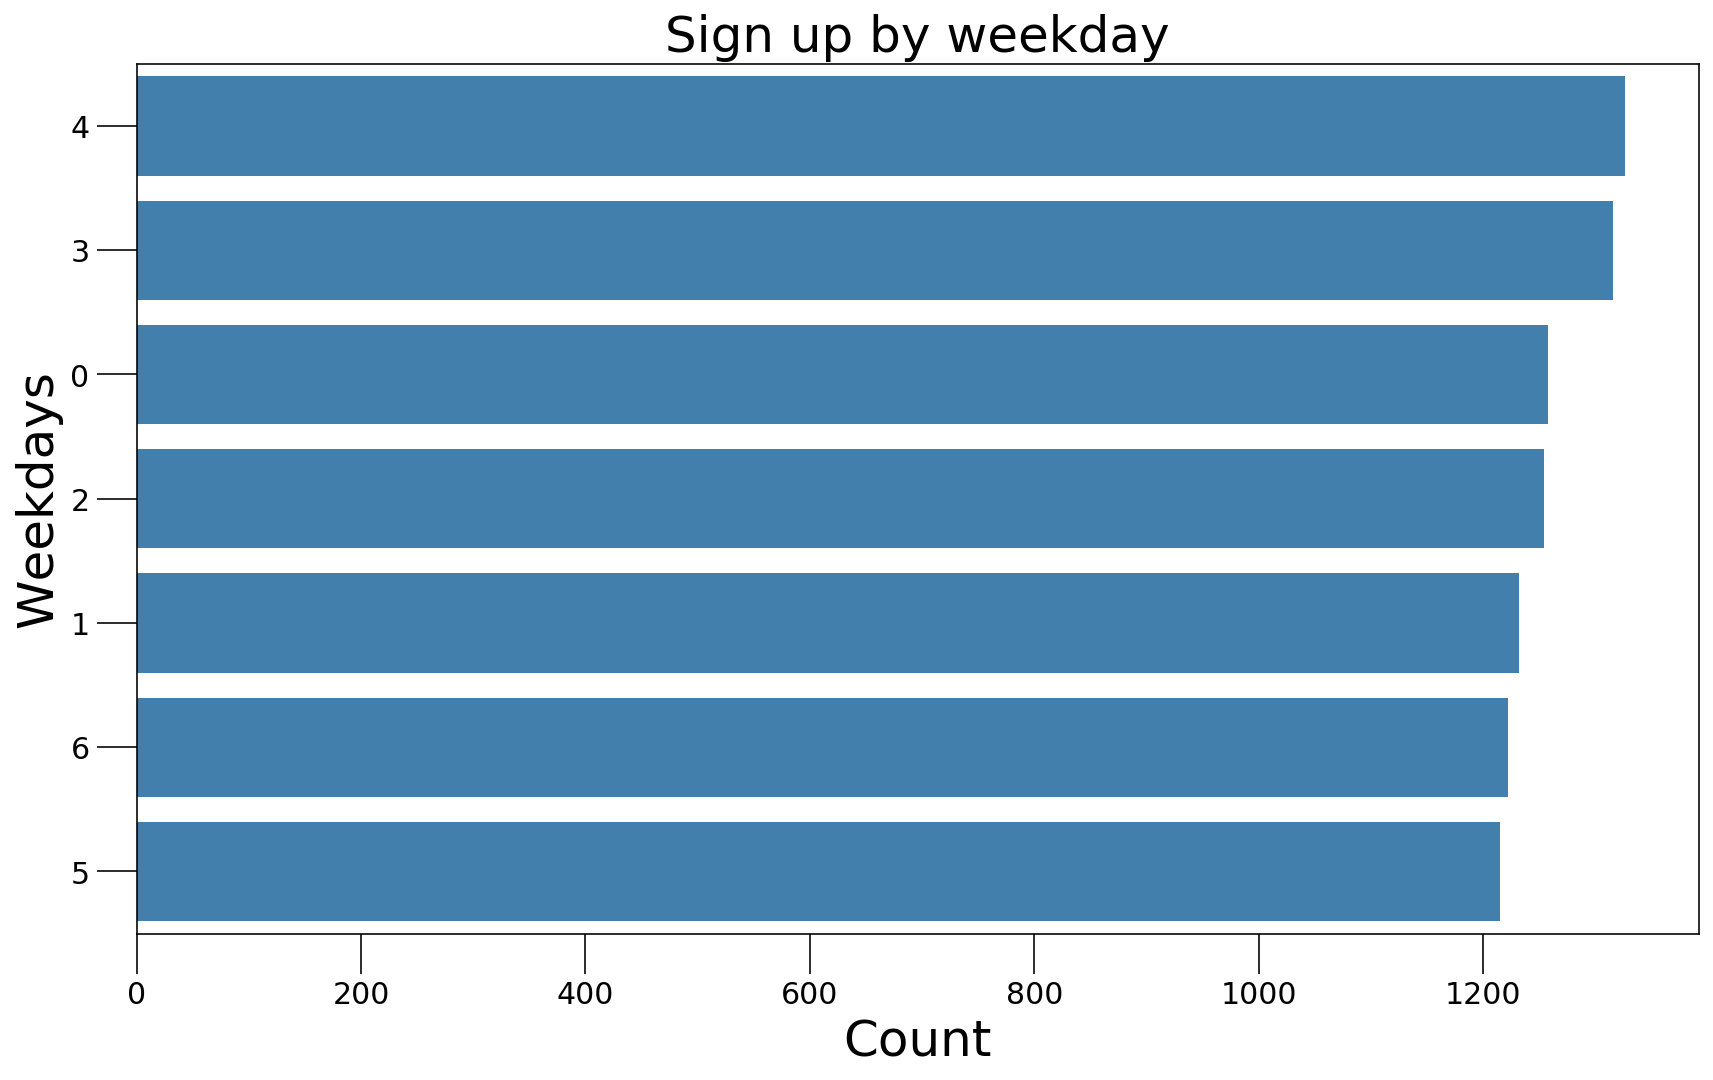

In [24]:
_=plt.rcParams['figure.figsize'] = [14,8]
_=sns.countplot(y = 'weekday', data = df, color='#3182bd', orient='h', order = df.weekday.value_counts().index)
_=plt.xlabel('Count', size = 25)
_=plt.ylabel('Weekdays', size = 25)
_=plt.title('Sign up by weekday', size = 25)
_=plt.tick_params(size = 20, labelsize = 15)

pd.DataFrame(df.groupby('weekday').size()).reset_index()

,creation_source,0
0,GUEST_INVITE,1588
1,ORG_INVITE,3188
2,PERSONAL_PROJECTS,764
3,SIGNUP,1898
4,SIGNUP_GOOGLE_AUTH,1385


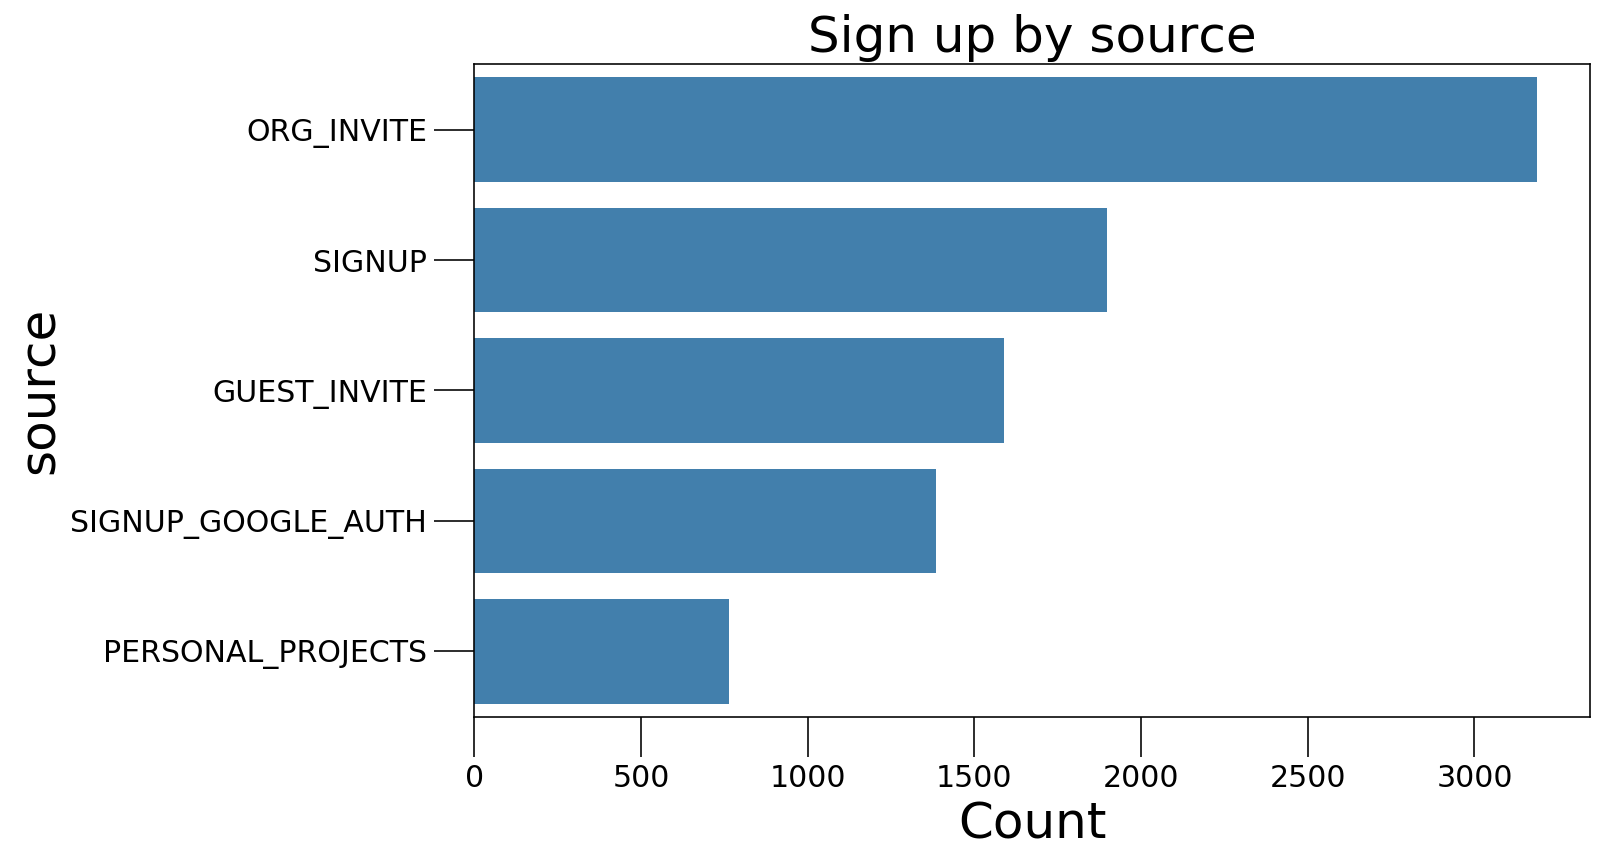

In [25]:
_=plt.rcParams['figure.figsize'] = [10,6]
_=sns.countplot(y = 'creation_source', data = df, color='#3182bd', orient='h', order = df.creation_source.value_counts().index)
_=plt.xlabel('Count', size = 25)
_=plt.ylabel('source', size = 25)
_=plt.title('Sign up by source', size = 25)
_=plt.tick_params(size = 20, labelsize = 15)

pd.DataFrame(df.groupby('creation_source').size()).reset_index()

In [26]:
pd.DataFrame(df.groupby('creation_source').size()/len(df))

,0
creation_source,
GUEST_INVITE,0.179984
ORG_INVITE,0.361328
PERSONAL_PROJECTS,0.086592
SIGNUP,0.215120
SIGNUP_GOOGLE_AUTH,0.156976


## Predictive Model: Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report

In [28]:
df.columns

Index(['user_id', 'time_stamp', 'visited', 'creation_time', 'name', 'email',
       'creation_source', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'month', 'weekday', 'duration', 'domain',
       'target'],
      dtype='object')

In [29]:
len(set(df.creation_source))

5

In [30]:
# create dummy variablesfor categorical variables
df = pd.concat([df,pd.get_dummies(df[['creation_source']], 
                                   prefix=['is'],
                                   drop_first=False)] ,axis=1)

In [31]:
df.columns

Index(['user_id', 'time_stamp', 'visited', 'creation_time', 'name', 'email',
       'creation_source', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'month', 'weekday', 'duration', 'domain',
       'target', 'is_GUEST_INVITE', 'is_ORG_INVITE', 'is_PERSONAL_PROJECTS',
       'is_SIGNUP', 'is_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [32]:
# split the data
from sklearn.model_selection import train_test_split

# set the predictor for the predictive model
X= df[['opted_in_to_mailing_list',
       'enabled_for_marketing_drip','month', 'weekday'
       ,'is_GUEST_INVITE',
       'is_ORG_INVITE', 'is_PERSONAL_PROJECTS',
       'is_SIGNUP', 'is_SIGNUP_GOOGLE_AUTH']]

# set the target variable
y = df['target']

#split data into training and testing
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state = 44)

In [33]:
np.random.seed(44)

#Create Classifier
rf=RandomForestClassifier(n_estimators=200, random_state=44, class_weight='balanced')

#Train the model using the training sets y_pred=clf.predict(X_test)
_=rf.fit(Xtrain,ytrain)

# test model on unseen data
pred_rf=rf.predict(Xtest)

## Evaluating the model

In [34]:
print("Accuracy score Random Forest:",metrics.accuracy_score(ytest, pred_rf))
print('\nClassification Report Random Forest')
print(classification_report(ytest, pred_rf))

Accuracy score Random Forest: 0.6112580279561768

Classification Report Random Forest
              precision    recall  f1-score   support

           0       0.81      0.67      0.74      2139
           1       0.20      0.35      0.26       508

    accuracy                           0.61      2647
   macro avg       0.51      0.51      0.50      2647
weighted avg       0.70      0.61      0.64      2647



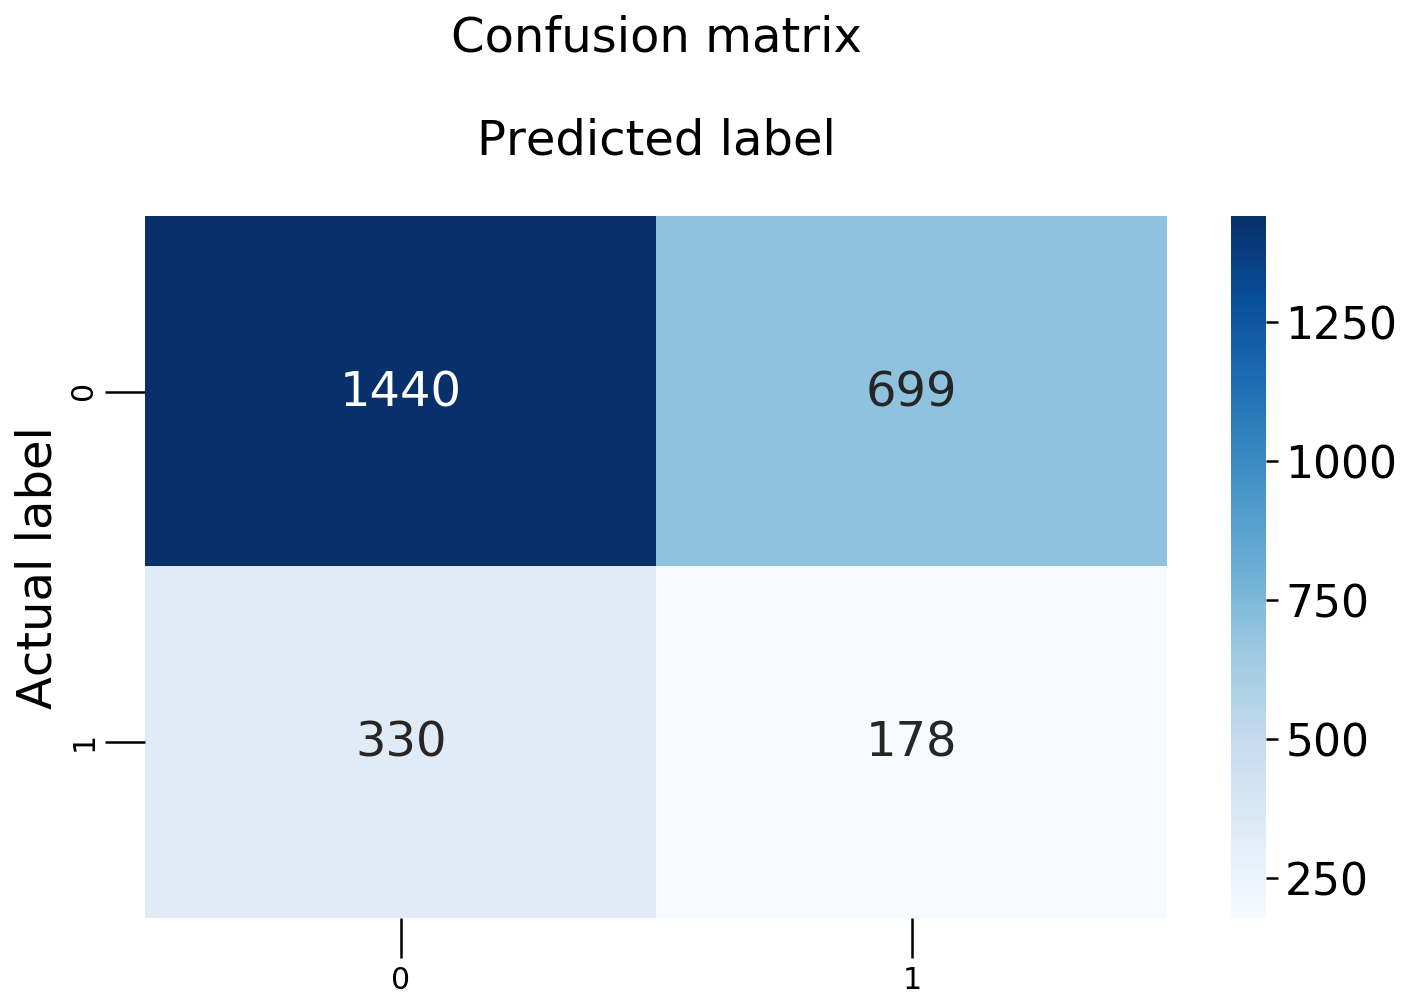

In [38]:
# test accuracy using confusion matrix
cnf_matrix = metrics.confusion_matrix(ytest, pred_rf)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
_=plt.xticks(tick_marks, class_names)
_=plt.yticks(tick_marks, class_names)
sns.set_context("notebook", font_scale=2)

# create heatmap
_=sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='Blues' ,fmt='g')
_=ax.xaxis.set_label_position("top")
_=plt.tight_layout()
_=plt.title('Confusion matrix\n', y=1.1)
_=plt.ylabel('Actual label')
_=plt.xlabel('Predicted label\n')
_=plt.tick_params(size = 20, labelsize = 15)

In [36]:
rf.feature_importances_

array([0.06524587, 0.05697652, 0.43847752, 0.35327223, 0.02067628,
       0.01708446, 0.01443025, 0.01759449, 0.01624238])

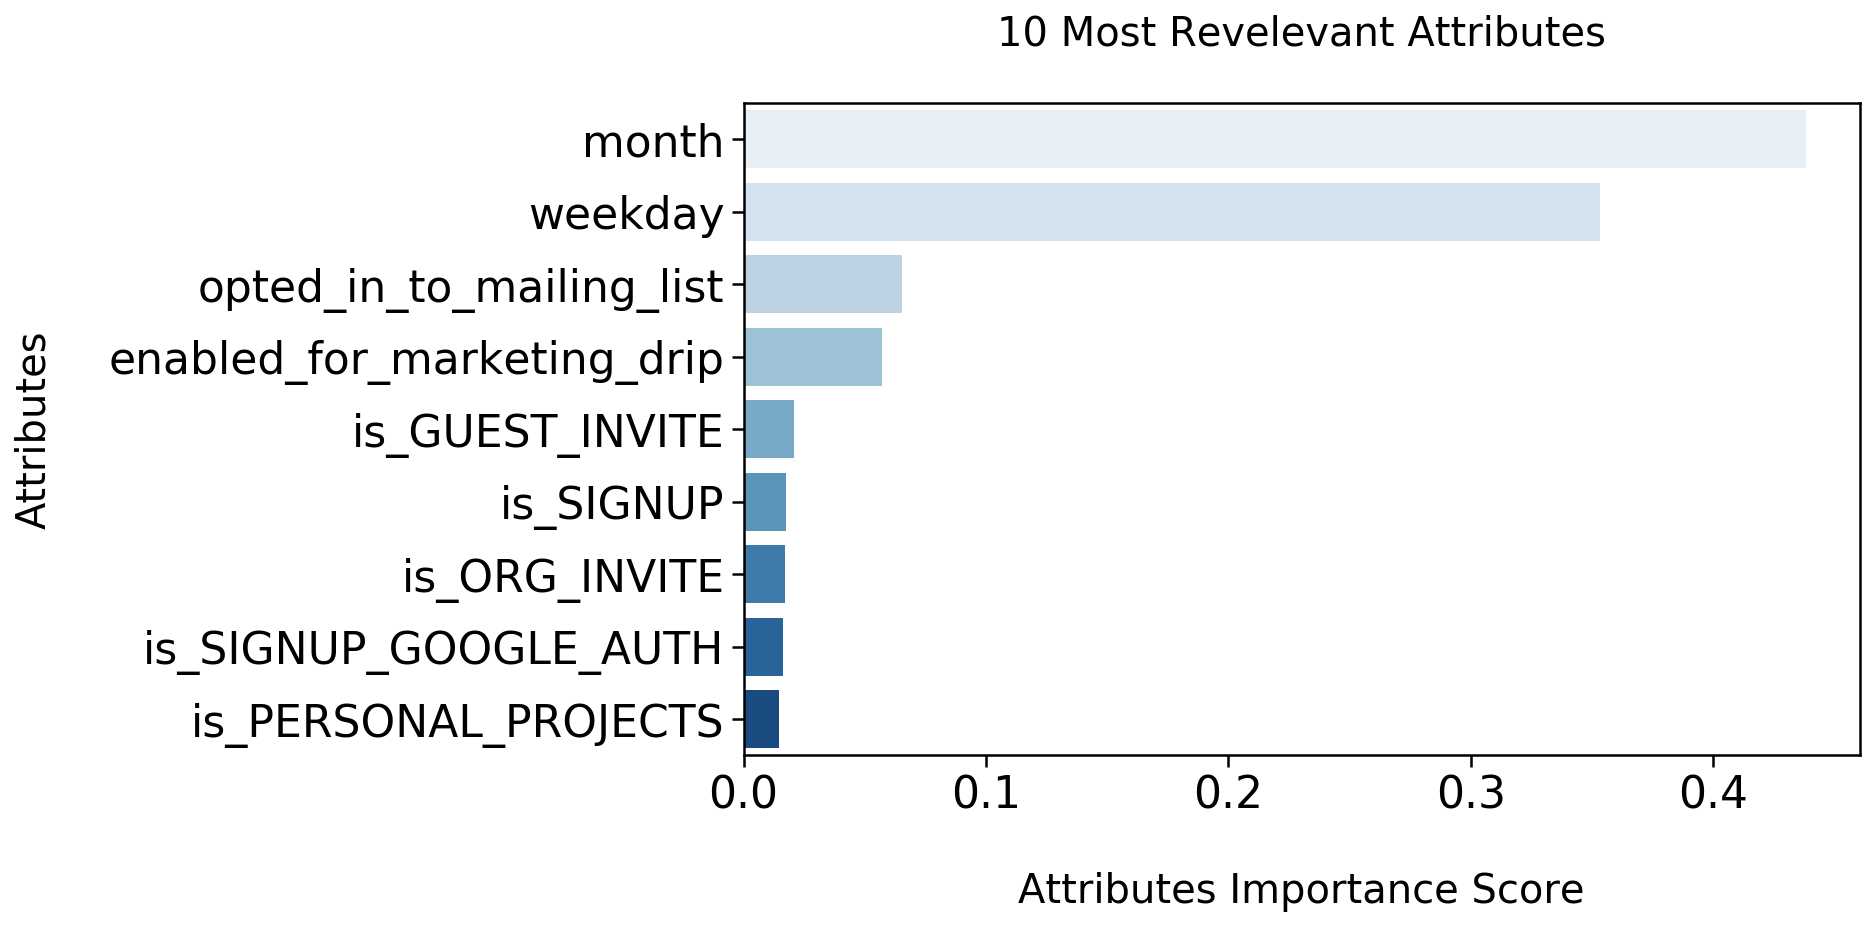

In [37]:
# set random seed to replicate results
np.random.seed(44)

# get variable names
model_vars = X.columns.to_list()

# create a data frame with variables importance and their score
feature_imp = pd.Series(rf.feature_importances_,index=model_vars).sort_values(ascending=False)

# plot 10 most relevant variables
_=sns.barplot(x=feature_imp[:10], y=feature_imp.index[:10], palette='Blues')
_=plt.title('10 Most Revelevant Attributes\n', fontsize = 20)
_=plt.xlabel('\nAttributes Importance Score', fontsize = 20)
_=plt.ylabel('Attributes\n', fontsize = 20)